# Exploring the use of Animal Faces dataset

### Importing basic packages
<code style="color:darkblue">
- numpy: computiong library for large/multidimensioanl array & functions
- pandas: data analysis & data manipulation</code>

In [1]:
import numpy as np
import pandas as pd
import os
import pathlib

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Layer, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
#from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

2024-06-10 13:32:36.906403: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-10 13:32:36.906513: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-10 13:32:37.061490: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
classes = {"cat": "0", "dog": "1", "wild": "2"}
allFilenames = []
allCategories = []
for classElement in classes:
    filenames = os.listdir("/kaggle/input/animal-faces/afhq/train/"+classElement)
    allFilenames += [classElement + "/" + file for file in filenames]
    allCategories += [classes[classElement]] * len(filenames)


df = pd.DataFrame({
    'filename': allFilenames,
    'class': allCategories
})

In [4]:
allFilenames_test = []
allCategories_test = []
for classElement in classes:
    filenames = os.listdir("/kaggle/input/animal-faces/afhq/train/" + classElement)
    allFilenames_test += [classElement + "/" + file for file in filenames]
    allCategories_test += [classes[classElement]] * len(filenames)


df_test = pd.DataFrame({
    'filename': allFilenames_test,
    'class': allCategories_test
})

In [5]:
df.head()

,filename,class
0,cat/pixabay_cat_000354.jpg,0
1,cat/pixabay_cat_002763.jpg,0
2,cat/pixabay_cat_001283.jpg,0
3,cat/pixabay_cat_003423.jpg,0
4,cat/flickr_cat_000496.jpg,0


In [6]:
df_training, df_validation = train_test_split(df, test_size = 0.20)
df_training = df_training.reset_index(drop = True)
df_validation = df_validation.reset_index(drop = True)

In [7]:
df_training

,filename,class
0,dog/pixabay_dog_003602.jpg,1
1,wild/flickr_wild_001068.jpg,2
2,dog/flickr_dog_000419.jpg,1
3,wild/flickr_wild_002798.jpg,2
4,dog/pixabay_dog_002505.jpg,1
...,...,...
11699,cat/pixabay_cat_002804.jpg,0
11700,wild/flickr_wild_003850.jpg,2
11701,wild/flickr_wild_003567.jpg,2
11702,cat/flickr_cat_000780.jpg,0


In [8]:
train_datagen = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.2,  
    height_shift_range = 0.2,    
    zoom_range = 0.2,        
    horizontal_flip = True, 
    rescale = 1./255,
    fill_mode = 'reflect'
)

train_generator = train_datagen.flow_from_dataframe(
    df_training, 
    "/kaggle/input/animal-faces/afhq/train/", 
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 11704 validated image filenames belonging to 3 classes.


In [9]:
df_example = df_training.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    df_example, 
    "/kaggle/input/animal-faces/afhq/train/", 
    x_col='filename',
    y_col='class',
    target_size = (150, 150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


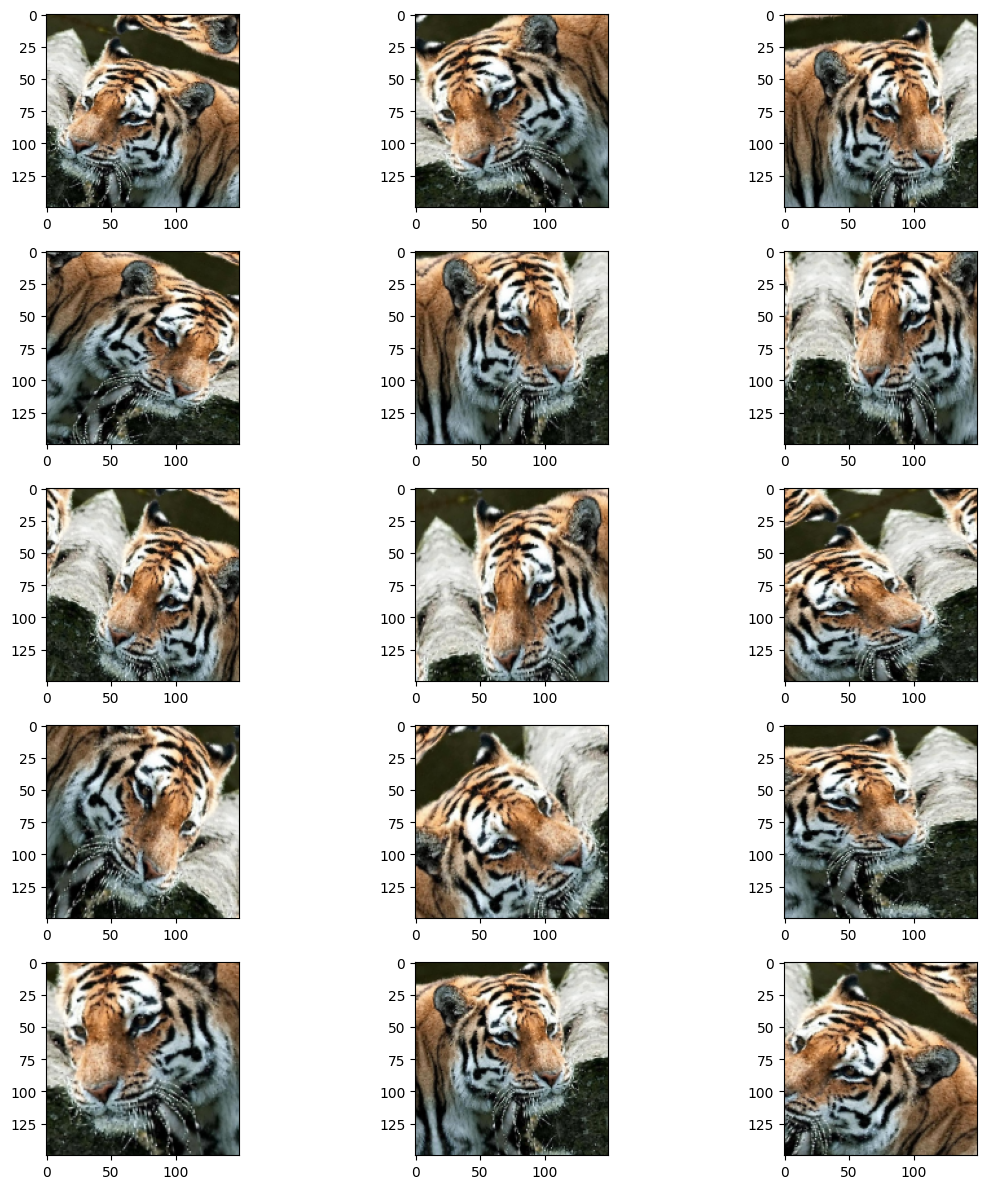

In [10]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [11]:
validation_datagen = ImageDataGenerator(rescale = 1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    df_validation, 
    "/kaggle/input/animal-faces/afhq/train/", 
    x_col = 'filename',
    y_col = 'class',
    target_size = (150, 150),
    class_mode = 'categorical',
    batch_size = 64
)

Found 2926 validated image filenames belonging to 3 classes.


***
# Importing a dataset from Kaggle

<code style="color:darkblue">In every train dataset cat & dog we have around 821 pictures that are called flickr_cat or flickr_dog and around 4834 pixabay_cat or pixabay_dog. Overall in the dataset I have around 5655 images for cat & around 5655 images for dog. Every image has 512×512 resolution. </code>

***
# Train the data

***
# Building the Convolutional Neural Networks (CNNs) model

In [12]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        2

In [13]:
early_stopping = EarlyStopping(patience=10)

reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, factor = 0.5, min_lr = 0.00001)

callbacks = [early_stopping, reduce_lr]

In [14]:
history = model.fit(
    train_generator, 
    epochs = 25,
    validation_data = validation_generator,
    callbacks = callbacks
)

Epoch 1/25


2024-06-10 13:33:35.518834: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1718026420.513668      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


183/183 [==============================] - 190s 995ms/step - loss: 1.1167 - accuracy: 0.5858 - val_loss: 3.9315 - val_accuracy: 0.3530 - lr: 0.0010
Epoch 2/25
183/183 [==============================] - 87s 476ms/step - loss: 0.6032 - accuracy: 0.7586 - val_loss: 1.1738 - val_accuracy: 0.5656 - lr: 0.0010
Epoch 3/25
183/183 [==============================] - 88s 479ms/step - loss: 0.4437 - accuracy: 0.8255 - val_loss: 2.5666 - val_accuracy: 0.6230 - lr: 0.0010
Epoch 4/25
183/183 [==============================] - 89s 484ms/step - loss: 0.3695 - accuracy: 0.8553 - val_loss: 0.5314 - val_accuracy: 0.8090 - lr: 0.0010
Epoch 5/25
183/183 [==============================] - 88s 478ms/step - loss: 0.3195 - accuracy: 0.8771 - val_loss: 0.3107 - val_accuracy: 0.8930 - lr: 0.0010
Epoch 6/25
183/183 [==============================] - 90s 492ms/step - loss: 0.2907 - accuracy: 0.8889 - val_loss: 0.6146 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 7/25
183/183 [==============================] - 88s 483m

In [15]:
test_gen = ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_dataframe(
    df_test, 
    "/kaggle/input/animal-faces/afhq/train/", 
    x_col='filename',
    y_col=None,
    class_mode= None,
    target_size = (150, 150),
    batch_size = 64,
    shuffle = False
)

Found 14630 validated image filenames.


In [16]:
predict = model.predict(test_generator, steps=int(np.ceil(df_test.shape[0] / 64)))

229/229 [==============================] - 40s 174ms/step


In [17]:
df_test['prediction'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
df_test['prediction'] = df_test['prediction'].replace(label_map)
df_test['prediction'] = df_test['prediction'].replace({ '1': 1, '0': 0 })

In [18]:
df_test['correctPred'] = df_test.apply(lambda x: str(x['class']) == str(x['prediction']), axis=1)

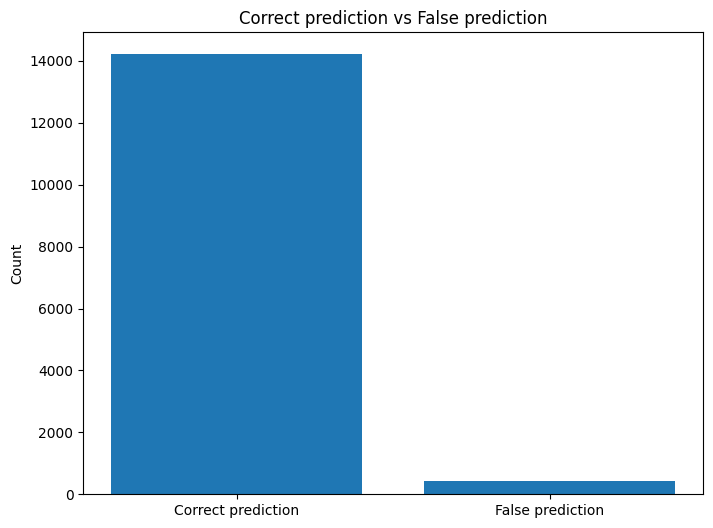

In [19]:
import matplotlib.pyplot as plt

# Assuming df_test has a column named 'correctPred' with boolean values or similar
correct_pred_counts = df_test['correctPred'].value_counts()

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(['Correct prediction', 'False prediction'], correct_pred_counts)
plt.title('Correct prediction vs False prediction')
plt.ylabel('Count')

# Show the plot
plt.show()


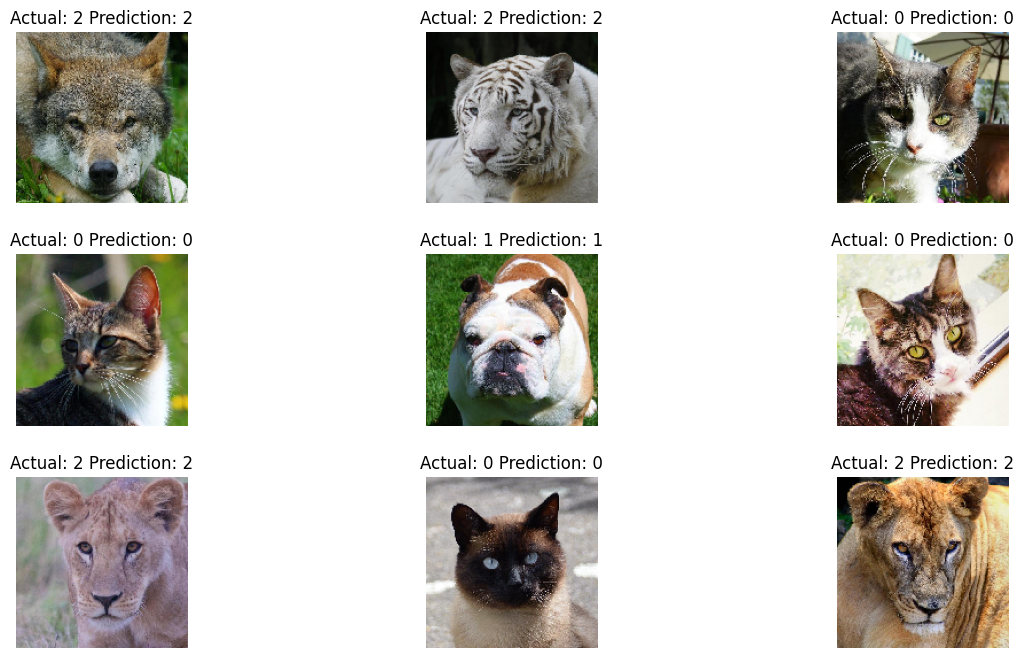

In [20]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import load_img

# Generate random indices
randomlist = []
for i in range(9):
    n = random.randint(0, len(df_test) - 1)
    randomlist.append(n)

# Create a figure and grid spec
fig = plt.figure(figsize=(15, 8))
gs1 = gridspec.GridSpec(3, 3)

# Create subplots and display images
for num, idx in enumerate(randomlist):
    row = df_test.iloc[idx]
    filename = row['filename']
    img = load_img(f"/kaggle/input/animal-faces/afhq/train/{filename}", target_size=(150, 150))
    ax = fig.add_subplot(gs1[num])
    ax.imshow(img)
    ax.set_title(f"Actual: {row['class']} Prediction: {row['prediction']}")
    ax.axis('off')

# Adjust the layout
fig.subplots_adjust(hspace=0.3)
plt.show()


In [21]:
classes = {"cat": "0", "dog": "1", "wild": "2"}
class_mapping = {"0": "cat", "1": "dog" , "2": "wild" }
df_test['class'].replace(class_mapping, inplace=True)
df_test['prediction'].unique()

array([0, '2', 1], dtype=object)

In [22]:
class_mapping = {0: "cat", 1: "dog" , "2": "wild" }
df_test['prediction'].replace(class_mapping, inplace=True)

In [23]:
df_test

,filename,class,prediction,correctPred
0,cat/pixabay_cat_000354.jpg,cat,cat,True
1,cat/pixabay_cat_002763.jpg,cat,cat,True
2,cat/pixabay_cat_001283.jpg,cat,cat,True
3,cat/pixabay_cat_003423.jpg,cat,cat,True
4,cat/flickr_cat_000496.jpg,cat,cat,True
...,...,...,...,...
14625,wild/pixabay_wild_000618.jpg,wild,dog,False
14626,wild/pixabay_wild_000552.jpg,wild,wild,True
14627,wild/flickr_wild_002275.jpg,wild,wild,True
14628,wild/pixabay_wild_000484.jpg,wild,wild,True


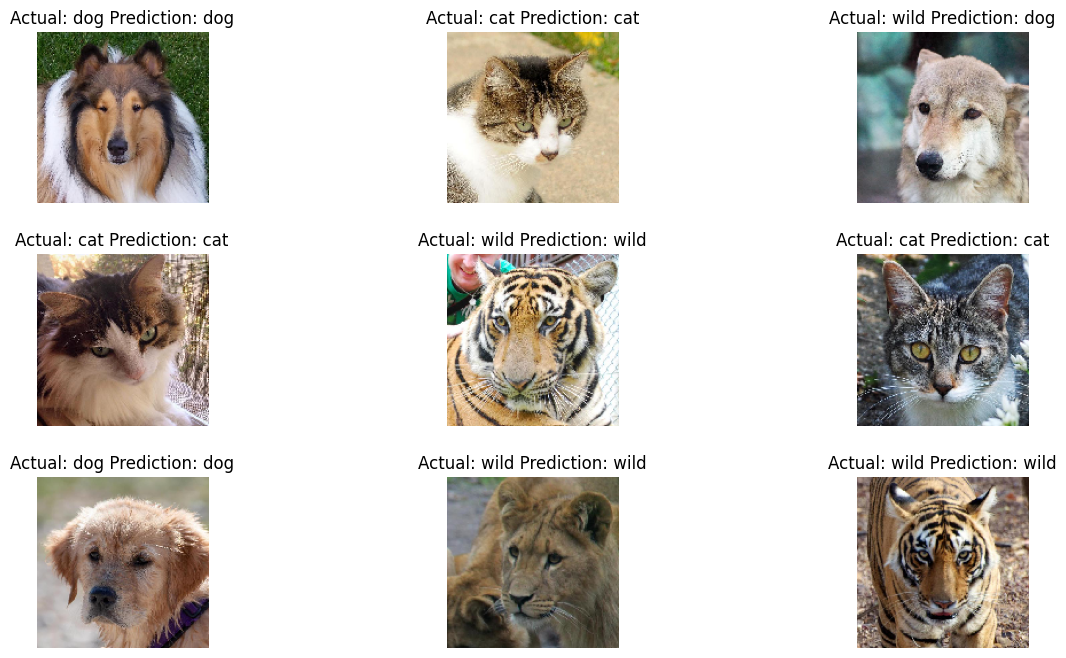

In [24]:
import random
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import load_img

# Generate random indices
randomlist = []
for i in range(9):
    n = random.randint(0, len(df_test) - 1)
    randomlist.append(n)

# Create a figure and grid spec
fig = plt.figure(figsize=(15, 8))
gs1 = gridspec.GridSpec(3, 3)

# Create subplots and display images
for num, idx in enumerate(randomlist):
    row = df_test.iloc[idx]
    filename = row['filename']
    img = load_img(f"/kaggle/input/animal-faces/afhq/train/{filename}", target_size=(150, 150))
    ax = fig.add_subplot(gs1[num])
    ax.imshow(img)
    ax.set_title(f"Actual: {row['class']} Prediction: {row['prediction']}")
    ax.axis('off')

# Adjust the layout
fig.subplots_adjust(hspace=0.3)
plt.show()
